In [1]:
import pandas as pd
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

import numpy as np

import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sn

pd.set_option('display.max_rows', 300) # specifies number of rows to show
pd.options.display.float_format = '{:40,.4f}'.format # specifies default number format to 4 decimal places
plt.style.use('ggplot') # specifies that graphs should use ggplot styling
%matplotlib inline

In [2]:
data = pd.read_csv('employment1.csv')

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32 entries, 0 to 31
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   employmentrate   32 non-null     float64
 1   disabled         32 non-null     float64
 2   noqualification  32 non-null     float64
dtypes: float64(3)
memory usage: 896.0 bytes


In [4]:
data.describe()

,employmentrate,disabled,noqualification
count,32.0000,32.0000,32.0000
mean,75.1813,11.5656,5.0813
std,3.9135,2.4978,2.2722
min,67.2000,5.8000,1.4000
25%,72.6500,10.3000,3.1250
50%,75.4500,11.6500,4.7500
75%,77.4000,12.5500,6.4250
max,84.9000,19.0000,9.3000


<AxesSubplot:>

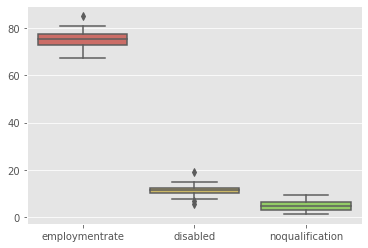

In [7]:
sn.boxplot(data=data,palette=sn.color_palette("hls", 8))

<AxesSubplot:>

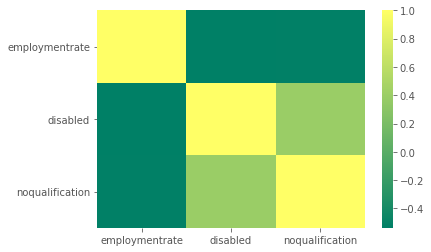

In [8]:
import seaborn as sb
r_pearson = data.corr()
sb.heatmap(data = r_pearson,cmap="summer")

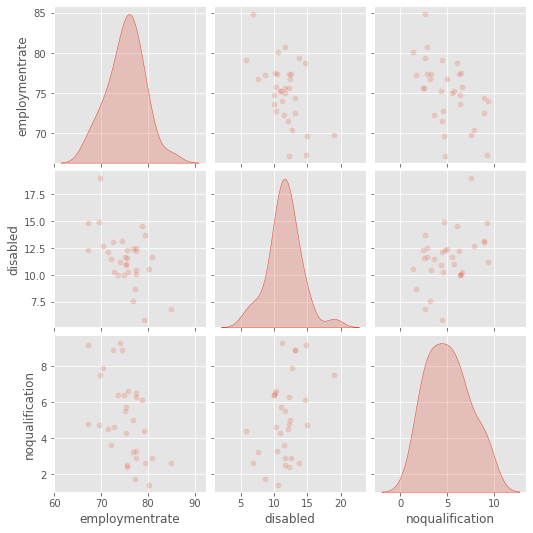

In [9]:
import seaborn as sns
sns.pairplot(data, diag_kind='kde', plot_kws={'alpha': 0.2})

/Users/luuuu/Desktop/CASA/anaconda3/envs/sds2021/lib/python3.9/site-packages/seaborn/axisgrid.py:1969: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


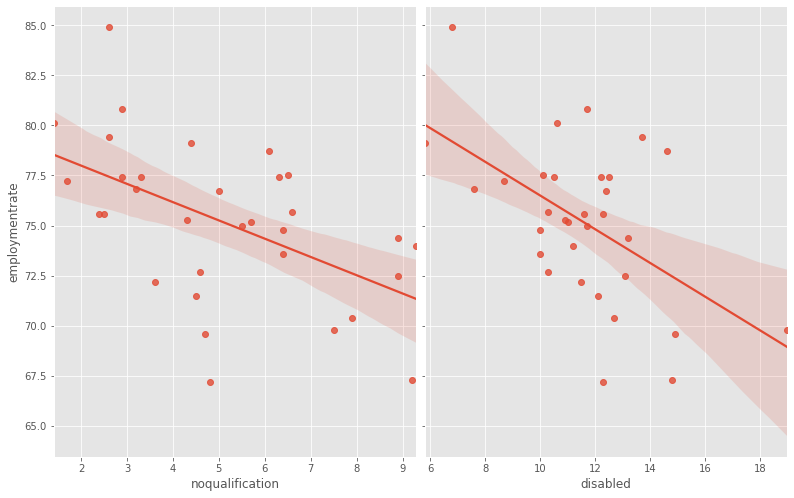

In [10]:
sns.pairplot(data, x_vars=['noqualification','disabled'], y_vars='employmentrate', size=7, aspect=0.8,kind = 'reg')

In [11]:
data.corr()

,employmentrate,disabled,noqualification
employmentrate,1.0000,-0.5372,-0.5297
disabled,-0.5372,1.0000,0.3896
noqualification,-0.5297,0.3896,1.0000


In [12]:
# subset the data
employ = data.loc[:,['employmentrate', 'noqualification', 'disabled']]

In [13]:
model = sm.formula.ols('employmentrate ~  noqualification + disabled', data).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         employmentrate   R-squared:                       0.410
Model:                            OLS   Adj. R-squared:                  0.369
Method:                 Least Squares   F-statistic:                     10.06
Date:                Tue, 18 Jan 2022   Prob (F-statistic):           0.000480
Time:                        01:05:51   Log-Likelihood:                -80.127
No. Observations:                  32   AIC:                             166.3
Df Residuals:                      29   BIC:                             170.7
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          85.5558      2.656     32.211      0.000      80.123      90.988
noqualification    -0.6506      0.267     -2.438      0.021      -1.196      -0.105
disabled           -0.6112      0.243     -2.518      0.018      -1.108      -0.115
==============================================================================
Omnibus:                        0.518   Durbin-Watson:                   2.243
Prob(Omnibus):                  0.772   Jarque-Bera (JB):                0.179
Skew:                          -0.183   Prob(JB):                        0.914
Kurtosis:                       3.019   Cond. No.                         62.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [14]:
df=data

In [15]:
# calculating VIF
# This function is adjusted from: https://stackoverflow.com/a/51329496/4667568
from statsmodels.stats.outliers_influence import variance_inflation_factor 
from statsmodels.tools.tools import add_constant

def drop_column_using_vif_(df, thresh=5):
    '''
    Calculates VIF each feature in a pandas dataframe, and repeatedly drop the columns with the highest VIF
    A constant must be added to variance_inflation_factor or the results will be incorrect

    :param df: the pandas dataframe containing only the predictor features, not the response variable
    :param thresh: (default 5) the threshould VIF value. If the VIF of a variable is greater than thresh, it should be removed from the dataframe
    :return: dataframe with multicollinear features removed
    '''
    while True:
        # adding a constatnt item to the data. add_constant is a function from statsmodels (see the import above)
        df_with_const = add_constant(df)

        vif_df = pd.Series([variance_inflation_factor(df_with_const.values, i) 
               for i in range(df_with_const.shape[1])], name= "VIF",
              index=df_with_const.columns).to_frame()

        # drop the const
        vif_df = vif_df.drop('const')
        
        # if the largest VIF is above the thresh, remove a variable with the largest VIF
        # If there are multiple variabels with VIF>thresh, only one of them is removed. This is because we want to keep as many variables as possible
        if vif_df.VIF.max() > thresh:
            # If there are multiple variables with the maximum VIF, choose the first one
            index_to_drop = vif_df.index[vif_df.VIF == vif_df.VIF.max()].tolist()[0]
            print('Dropping: {}'.format(index_to_drop))
            df = df.drop(columns = index_to_drop)
        else:
            # No VIF is above threshold. Exit the loop
            print('There is not multicollinearity.')
            break

    return df

In [16]:
employ_new = drop_column_using_vif_(employ.drop('employmentrate', axis=1))

There is not multicollinearity.


/Users/luuuu/Desktop/CASA/anaconda3/envs/sds2021/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


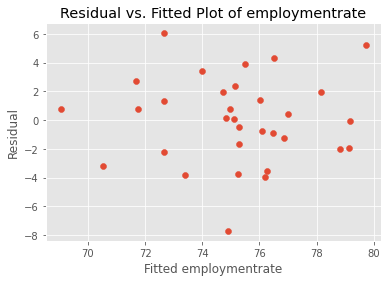

In [17]:
# plot 
plt.scatter(model.fittedvalues, model.resid)
# adding title and labels
plt.xlabel('Fitted employmentrate')
plt.ylabel('Residual')
plt.title('Residual vs. Fitted Plot of employmentrate')
plt.show()

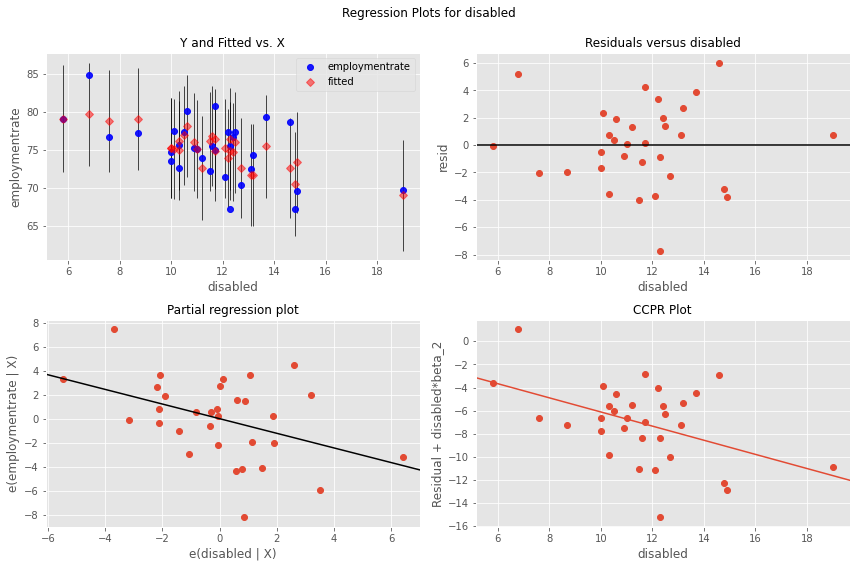

In [18]:
fig = plt.figure(figsize=(12,8))
fig = sm.graphics.plot_regress_exog(model, 'disabled', fig=fig)

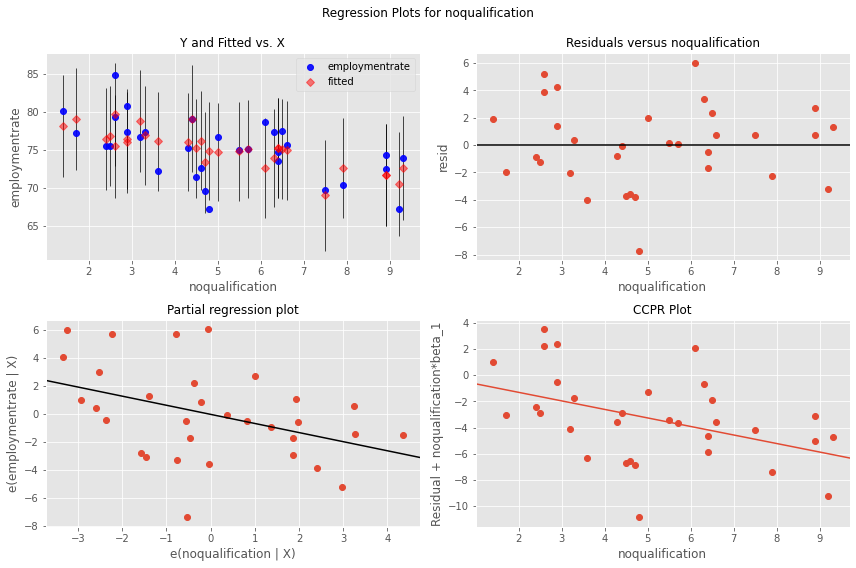

In [19]:
fig = plt.figure(figsize=(12,8))
fig = sm.graphics.plot_regress_exog(model, 'noqualification', fig=fig)